In [1]:
import pyregion
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
# Function to read DS9 region file
def read_ds9_region(region_file):
    regions = pyregion.open(region_file)
    return regions

# Function to extract region data from data cube
def extract_region_data(data_cube, regions, header):
    mask = regions.get_mask(hdu=fits.PrimaryHDU(header=header, data=data_cube[0]))
    masked_data_cube = data_cube * mask
    return masked_data_cube

# Function to integrate the spectrum
def integrate_spectrum(region_data):
    integrated_spectrum = np.nansum(region_data, axis=(1, 2))
    return integrated_spectrum

# Function to plot the spectrum
def plot_spectrum(integrated_spectrum, header):
    filter_cm1_min = header['HIERARCH filter_cm1_min']
    filter_cm1_max = header['HIERARCH filter_cm1_max']
    step_nb = header['STEP_NB']

    wavenumber_axis = np.linspace(filter_cm1_min, filter_cm1_max, step_nb)
    wavelength_axis = 1e8 / wavenumber_axis  # Convert cm^-1 to Angstroms

    plt.figure(figsize=(10, 6))
    plt.plot(wavelength_axis, integrated_spectrum, label='Integrated Spectrum')
    plt.xlabel('Wavelength (Å)')
    plt.ylabel('Flux')
    plt.title('Integrated Spectrum')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
region_file = 'region_1.reg'  # Replace with your DS9 region file
regions = read_ds9_region(region_file)

with fits.open('corrected_data_cube.fits') as hdul:
    data_cube = hdul[0].data
    header = hdul[0].header

region_data = extract_region_data(data_cube, regions, header)
integrated_spectrum = integrate_spectrum(region_data)
plot_spectrum(integrated_spectrum, header)

KeyboardInterrupt: 

In [ ]:
def plot_2spectrum(corrected_spectrum, uncorrected_spectrum, header,figname):
    filter_cm1_min = header['HIERARCH filter_cm1_min']
    filter_cm1_max = header['HIERARCH filter_cm1_max']
    step_nb = header['STEP_NB']

    wavenumber_axis = np.linspace(filter_cm1_min, filter_cm1_max, step_nb)
    wavelength_axis = 1e8 / wavenumber_axis  # Convert cm^-1 to Angstroms

    plt.figure(figsize=(10, 6))
    plt.plot(wavelength_axis, corrected_spectrum/5303, label='Corrected Spectrum', color='blue')
    plt.plot(wavelength_axis, uncorrected_spectrum/5303, label='Uncorrected Spectrum', color='red')
    plt.xlabel('Wavelength (Å)')
    plt.ylabel('Flux')
    plt.title('Integrated Spectrum')
    plt.savefig(figname)
    plt.legend()
    plt.grid(True)
    plt.show()
figname = '/home/lucas/LUCI/Examples/crab_c3_field1/Results_paper/comp_spectra.jpeg'
with fits.open('corrected_data_cube.fits') as hdul_corrected:
    corrected_data_cube = hdul_corrected[0].data
    header_corrected = hdul_corrected[0].header
    
with fits.open('2912251z.fits') as hdul_uncorrected:
    uncorrected_data_cube = hdul_uncorrected[0].data
    header_uncorrected = hdul_uncorrected[0].header

# Extract region data
corrected_region_data = extract_region_data(corrected_data_cube, regions, header_corrected)
uncorrected_region_data = extract_region_data(uncorrected_data_cube, regions, header_uncorrected)

# Integrate spectra
corrected_spectrum = integrate_spectrum(corrected_region_data)
uncorrected_spectrum = integrate_spectrum(uncorrected_region_data)

# Plot spectra
plot_2spectrum(corrected_spectrum, uncorrected_spectrum, header_corrected,figname)

In [3]:
with fits.open('velocity_slice.fits') as hdul:
    data_cube = hdul[0].data
    header = hdul[0].header

# Select a specific channel or slice from the cube
# Assuming we want to plot the middle channel
mid_channel = data_cube.shape[0] // 2
image_data = data_cube[mid_channel]

# Update the header for 2D image data
new_header = header.copy()
new_header['NAXIS'] = 2
new_header['NAXIS1'] = image_data.shape[1]
new_header['NAXIS2'] = image_data.shape[0]

# Remove 3D-specific keywords, if they exist
keys_to_remove = ['CTYPE3', 'CRPIX3', 'CRVAL3', 'CDELT3', 'WCSAXES', 'NAXIS3']
for key in keys_to_remove:
    
    if key in new_header:
        del new_header[key]

# Save the 2D image FITS file
fits.writeto('velocity_slice_image.fits', image_data, new_header, overwrite=True)

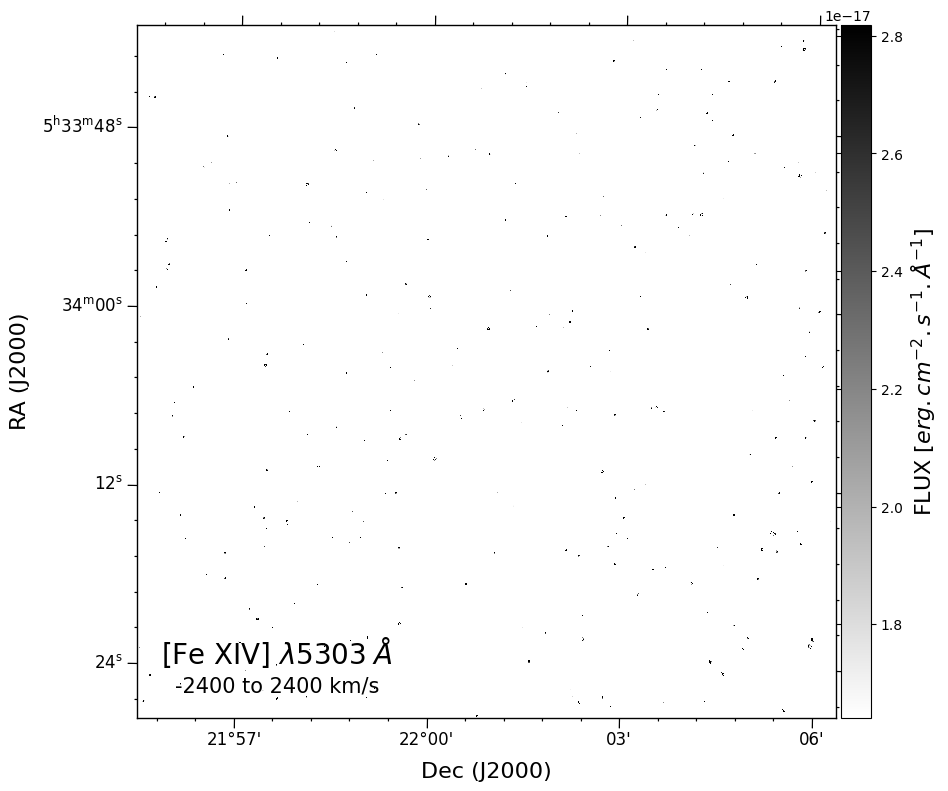

In [4]:
import aplpy
hh = aplpy.FITSFigure('velocity_slice_image.fits',dimensions=[1,0])
#min_val, max_val = np.percentile(data, [2.5, 95.5])
hh.show_grayscale(vmin=1.64146e-17, vmax= 2.81913e-17
                  ,stretch= 'linear')
                  # can add here inverted = True
hh.set_theme('publication')
hh.axis_labels.set_font(size=16)
hh.tick_labels.set_font(size=12)

#hh.add_grid()
#hh.add_label(0.1, 0.15, 'Field 1', relative=True,size=18)
hh.add_colorbar()
hh.colorbar.set_width(0.3)
hh.colorbar.set_location('right')
hh.colorbar.set_axis_label_text('FLUX [$erg.cm^{-2}.s^{-1}.{\AA}^{-1}$]')
hh.colorbar.set_axis_label_font(size=16)
hh.add_label(0.2, 0.095, '[Fe XIV] $\lambda5303 \; {\AA}$', relative=True,size=20)
hh.add_label(0.2, 0.045, '-2400 to 2400 km/s', relative=True,size=15)
#hh.save('iron_slice_field1_skysubtracted_v0.jpeg')

Image saved to iron_slice_5000_final.fits
Velocity range: (-5000, 5000) km/s
Emission line: 5303 Å
INFO: Auto-setting vmin to -8.510e-19 [aplpy.core]
INFO: Auto-setting vmax to  9.990e-19 [aplpy.core]


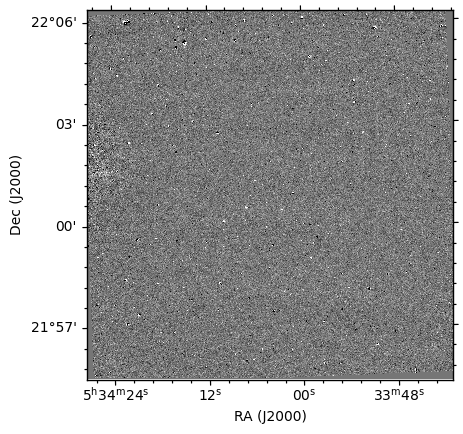

In [6]:
import numpy as np
from astropy.io import fits
import aplpy
import matplotlib.pyplot as plt

def convert_fits_to_image(fits_file, emission_line, velocity_range, output_file):
    # Open the FITS file and load the data
    with fits.open(fits_file) as hdul:
        data_cube = hdul[0].data
        header = hdul[0].header

    # Find the middle channel (simplified approach if specific channels are unclear)
    mid_channel = data_cube.shape[0] // 2
    image_data = data_cube[mid_channel]

    # Update the header for 2D image data
    new_header = header.copy()
    new_header['NAXIS'] = 2
    new_header['NAXIS1'] = image_data.shape[1]
    new_header['NAXIS2'] = image_data.shape[0]

    # Remove 3D-specific keywords, if they exist
    keys_to_remove = ['CTYPE3', 'CRPIX3', 'CRVAL3', 'CDELT3', 'WCSAXES', 'NAXIS3']
    for key in keys_to_remove:
        if key in new_header:
            del new_header[key]

    # Add custom metadata related to the velocity range and other parameters
    new_header['VELO_MIN'] = velocity_range[0]
    new_header['VELO_MAX'] = velocity_range[1]
    new_header['EMLINE'] = emission_line
    new_header['SLICE_CT'] = 1  # Since we're working with a single slice here
    new_header['COMMENT'] = "Velocity slice image"

    # Save the 2D image FITS file
    fits.writeto(output_file, image_data, new_header, overwrite=True)

    # Print out information for the user
    print(f"Image saved to {output_file}")
    print(f"Velocity range: {velocity_range} km/s")
    print(f"Emission line: {emission_line} Å")

    # Visualize the slice using aplpy
    fig = plt.figure()
    f = aplpy.FITSFigure(output_file, figure=fig)
    f.show_grayscale()
    plt.show()

# Example usage
fits_file = 'continuum_subtracted.fits'
emission_line = 5303  # Angstroms
velocity_range = (-5000, 5000)  # km/s
output_file = 'iron_slice_5000_final.fits'
#continuum_subtracted.fits
convert_fits_to_image(fits_file, emission_line, velocity_range, output_file)

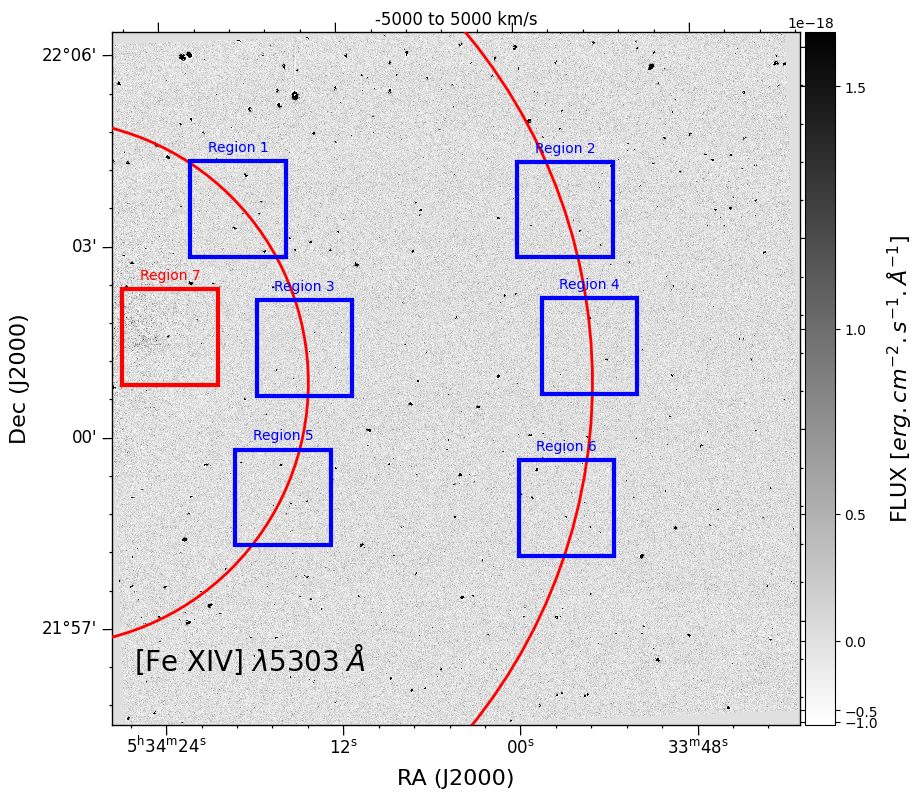

In [17]:
hh = aplpy.FITSFigure('iron_slice_2400_final.fits')
#min_val, max_val = np.percentile(data, [2.5, 95.5])
hh.show_grayscale(vmin=-8.510e-19 , vmax= 15.990e-19
                  ,stretch= 'power')
                  # can add here inverted = True
hh.set_theme('publication')
hh.axis_labels.set_font(size=16)
hh.tick_labels.set_font(size=12)

#hh.add_grid()
#hh.add_label(0.1, 0.15, 'Field 1', relative=True,size=18)
hh.add_colorbar()
hh.colorbar.set_width(0.3)
hh.colorbar.set_location('right')
hh.colorbar.set_axis_label_text('FLUX [$erg.cm^{-2}.s^{-1}.{\AA}^{-1}$]')
hh.colorbar.set_axis_label_font(size=16)
hh.show_regions('../Luci_outputs/paper.reg', layer=False)
hh.set_title('-5000 to 5000 km/s')
hh.add_label(0.2, 0.095, '[Fe XIV] $\lambda5303 \; {\AA}$', relative=True,size=20)
#hh.add_label(0.2, 0.045, '-2400 to 2400 km/s', relative=True,size=15)
hh.save('iron_slice_5000_final_today.jpeg')

Image saved to iron_slice_image_5000.fits
Velocity range: (-5000, 5000) km/s
Emission line: 5303 Å
INFO: Auto-setting vmin to -1.200e-18 [aplpy.core]
INFO: Auto-setting vmax to  1.528e-18 [aplpy.core]


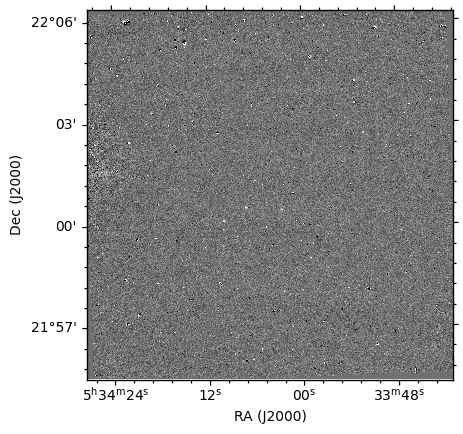

In [3]:
import numpy as np
from astropy.io import fits
import aplpy
import matplotlib.pyplot as plt

def convert_fits_to_image(fits_file, emission_line, velocity_range, output_file):
    # Open the FITS file and load the data
    with fits.open(fits_file) as hdul:
        data_cube = hdul[0].data
        header = hdul[0].header

    # Find the middle channel (simplified approach if specific channels are unclear)
    mid_channel = data_cube.shape[0] // 2
    image_data = data_cube[mid_channel]

    # Update the header for 2D image data
    new_header = header.copy()
    new_header['NAXIS'] = 2
    new_header['NAXIS1'] = image_data.shape[1]
    new_header['NAXIS2'] = image_data.shape[0]

    # Remove 3D-specific keywords, if they exist
    keys_to_remove = ['CTYPE3', 'CRPIX3', 'CRVAL3', 'CDELT3', 'WCSAXES', 'NAXIS3']
    for key in keys_to_remove:
        if key in new_header:
            del new_header[key]

    # Add custom metadata related to the velocity range and other parameters
    new_header['VELO_MIN'] = velocity_range[0]
    new_header['VELO_MAX'] = velocity_range[1]
    new_header['EMLINE'] = emission_line
    new_header['SLICE_CT'] = 1  # Since we're working with a single slice here
    new_header['COMMENT'] = "Velocity slice image"

    # Save the 2D image FITS file
    fits.writeto(output_file, image_data, new_header, overwrite=True)

    # Print out information for the user
    print(f"Image saved to {output_file}")
    print(f"Velocity range: {velocity_range} km/s")
    print(f"Emission line: {emission_line} Å")

    # Visualize the slice using aplpy
    fig = plt.figure()
    f = aplpy.FITSFigure(output_file, figure=fig)
    f.show_grayscale()
    plt.show()

# Example usage
fits_file = 'continuum_subtracted.fits'
emission_line = 5303  # Angstroms
velocity_range = (-5000, 5000)  # km/s
output_file = 'iron_slice_image_5000.fits'
#continuum_subtracted.fits
convert_fits_to_image(fits_file, emission_line, velocity_range, output_file)

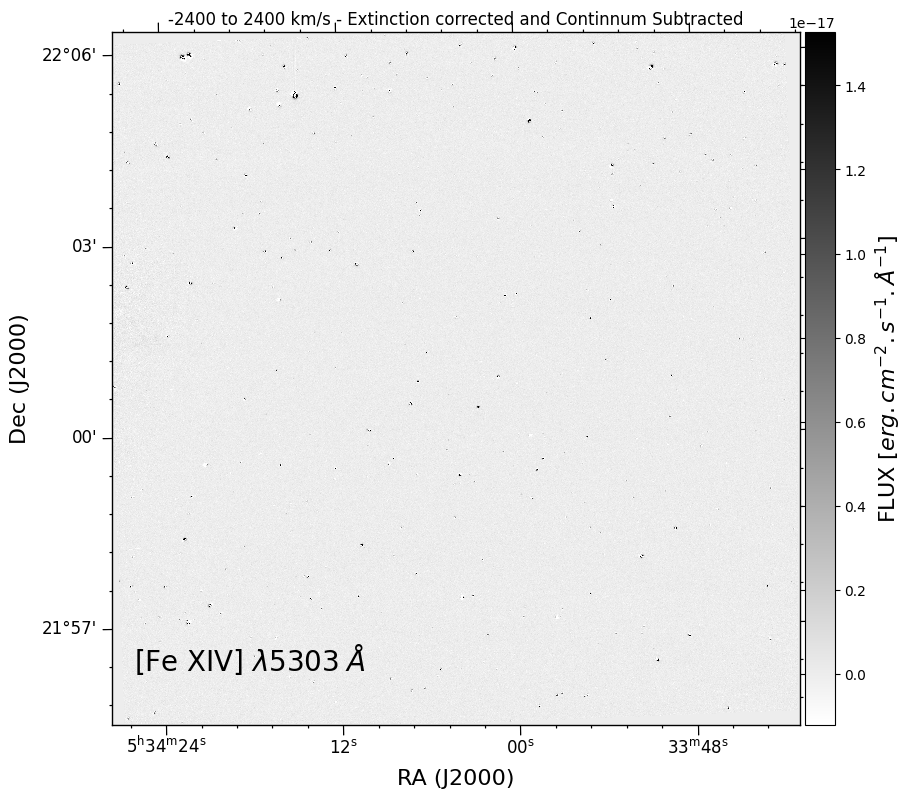

In [7]:
hh = aplpy.FITSFigure('iron_slice_image_test.fits')
#min_val, max_val = np.percentile(data, [2.5, 95.5])
hh.show_grayscale(vmin=-1.200e-18, vmax= 1.528e-1
                  ,stretch= 'linear')
                  # can add here inverted = True
hh.set_theme('publication')
hh.axis_labels.set_font(size=16)
hh.tick_labels.set_font(size=12)

#hh.add_grid()
#hh.add_label(0.1, 0.15, 'Field 1', relative=True,size=18)
hh.add_colorbar()
hh.colorbar.set_width(0.3)
hh.colorbar.set_location('right')
hh.colorbar.set_axis_label_text('FLUX [$erg.cm^{-2}.s^{-1}.{\AA}^{-1}$]')
hh.colorbar.set_axis_label_font(size=16)
hh.set_title('-2400 to 2400 km/s - Extinction corrected and Continnum Subtracted')
hh.add_label(0.2, 0.095, '[Fe XIV] $\lambda5303 \; {\AA}$', relative=True,size=20)
#hh.add_label(0.2, 0.045, '-2400 to 2400 km/s', relative=True,size=15)
#hh.save('iron_slice_field1_ECANDCS_2400.jpeg')

Image saved to iron_slice_image_orignal.fits
Velocity range: (-2400, 2400) km/s
Emission line: 5303 Å
INFO: Auto-setting vmin to -5.492e-19 [aplpy.core]
INFO: Auto-setting vmax to  6.096e-18 [aplpy.core]


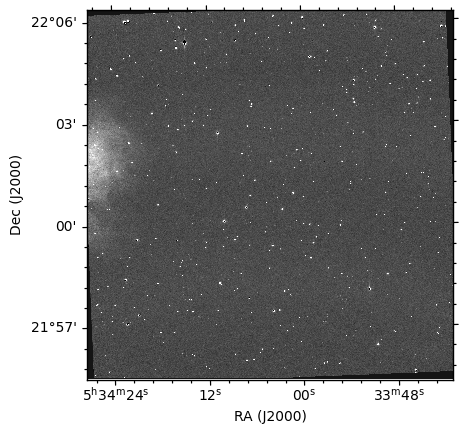

In [26]:
import numpy as np
from astropy.io import fits
import aplpy
import matplotlib.pyplot as plt

def convert_fits_to_image(fits_file, emission_line, velocity_range, output_file):
    # Open the FITS file and load the data
    with fits.open(fits_file) as hdul:
        data_cube = hdul[0].data
        header = hdul[0].header

    # Find the middle channel (simplified approach if specific channels are unclear)
    mid_channel = data_cube.shape[0] // 2
    image_data = data_cube[mid_channel]

    # Update the header for 2D image data
    new_header = header.copy()
    new_header['NAXIS'] = 2
    new_header['NAXIS1'] = image_data.shape[1]
    new_header['NAXIS2'] = image_data.shape[0]

    # Remove 3D-specific keywords, if they exist
    keys_to_remove = ['CTYPE3', 'CRPIX3', 'CRVAL3', 'CDELT3', 'WCSAXES', 'NAXIS3']
    for key in keys_to_remove:
        if key in new_header:
            del new_header[key]

    # Add custom metadata related to the velocity range and other parameters
    new_header['VELO_MIN'] = velocity_range[0]
    new_header['VELO_MAX'] = velocity_range[1]
    new_header['EMLINE'] = emission_line
    new_header['SLICE_CT'] = 1  # Since we're working with a single slice here
    new_header['COMMENT'] = "Velocity slice image"

    # Save the 2D image FITS file
    fits.writeto(output_file, image_data, new_header, overwrite=True)

    # Print out information for the user
    print(f"Image saved to {output_file}")
    print(f"Velocity range: {velocity_range} km/s")
    print(f"Emission line: {emission_line} Å")

    # Visualize the slice using aplpy
    fig = plt.figure()
    f = aplpy.FITSFigure(output_file, figure=fig)
    f.show_grayscale()
    plt.show()

# Example usage
fits_file = '2912251z.fits'
emission_line = 5303  # Angstroms
velocity_range = (-2400, 2400)  # km/s
output_file = 'iron_slice_image_orignal.fits'
#continuum_subtracted.fits
convert_fits_to_image(fits_file, emission_line, velocity_range, output_file)

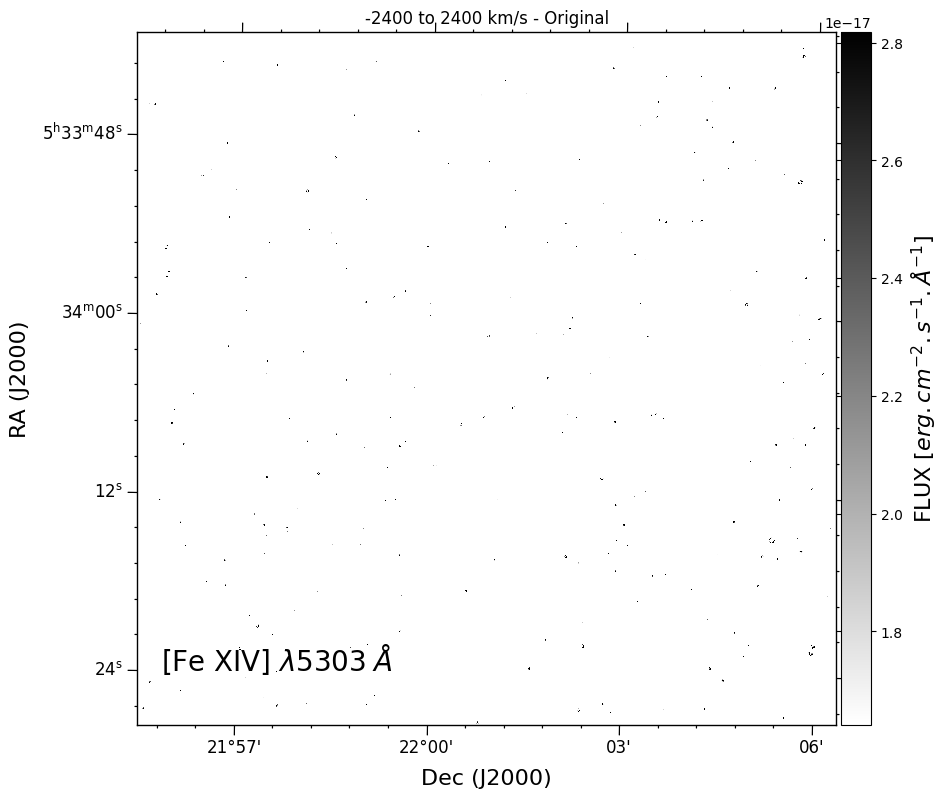

In [29]:
hh = aplpy.FITSFigure('iron_slice_image_orignal.fits',dimensions=[1,0])
#min_val, max_val = np.percentile(data, [2.5, 95.5])
hh.show_grayscale(vmin=1.64146e-17, vmax= 2.81913e-17
                  ,stretch= 'linear')
                  # can add here inverted = True
hh.set_theme('publication')
hh.axis_labels.set_font(size=16)
hh.tick_labels.set_font(size=12)

#hh.add_grid()
#hh.add_label(0.1, 0.15, 'Field 1', relative=True,size=18)
hh.add_colorbar()
hh.colorbar.set_width(0.3)
hh.colorbar.set_location('right')
hh.colorbar.set_axis_label_text('FLUX [$erg.cm^{-2}.s^{-1}.{\AA}^{-1}$]')
hh.colorbar.set_axis_label_font(size=16)
hh.set_title('-2400 to 2400 km/s - Original')
hh.add_label(0.2, 0.095, '[Fe XIV] $\lambda5303 \; {\AA}$', relative=True,size=20)
#hh.add_label(0.2, 0.045, '-2400 to 2400 km/s', relative=True,size=15)
hh.save('iron_slice_field1_original_2400.jpeg')